In [28]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output

words = open('the-verdict.txt').read()

vocab = ['.'] + sorted(set(''.join(words)))  # sorted unique chars
vocab_size = len(vocab)

itos = {i:s for i,s in enumerate(vocab)}  # index to string
stoi = {s:i for i,s in enumerate(vocab)}  # string to index

print('vocab_size:', vocab_size)

# list of tokens
def encode(text):
    return [stoi[s] for s in text]

# for each token put letter and join with empty string
def decode(ids):
    return ''.join(itos[i] for i in ids)

vocab_size: 63


In [2]:
encoded = encode(words)

In [3]:
encoded[:10]

[22, 2, 21, 14, 17, 2, 37, 48, 59, 37]

In [4]:
#hyperparameter
block_size = 3
n_embd = 2

In [5]:
len(encoded)-block_size

20476

In [6]:
# Goal: train model to predict next character based on sequence of previous characters (N)  
# Dataset: list of triples (input, output), supervised learning
X = []
y = []
for i in range(len(encoded)-block_size):
    X.append(encoded[i:i+block_size])  # 3 chars
    y.append(encoded[i+block_size])  # next char

# list to tensor (to train model)
X = torch.tensor(X)
y = torch.tensor(y)

In [7]:
X

tensor([[22,  2, 21],
        [ 2, 21, 14],
        [21, 14, 17],
        ...,
        [ 2, 37, 54],
        [37, 54, 56],
        [54, 56, 10]])

In [8]:
y

tensor([14, 17,  2,  ..., 56, 10,  4])

In [9]:
j = 0
for input_, output in zip(X, y):
    print(f"When input is {decode(input_.tolist())!r}, output is {decode([output.item()])!r}")
    j += 1
    if j == 5:
        break

When input is 'I H', output is 'A'
When input is ' HA', output is 'D'
When input is 'HAD', output is ' '
When input is 'AD ', output is 'a'
When input is 'D a', output is 'l'


In [56]:
# Pythorch NN model class
class NGram(nn.Module):
    def __init__(self, vocab_size, block_size, n_embd):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embd = n_embd

        self.emb = nn.Embedding(vocab_size, n_embd)  # lookup table of shape [vocab_size x n_embd]
        self.fc = nn.Linear(block_size*n_embd, vocab_size)  # block_size*n_embd is flattened vector, vocab_size is output

        # output logits=input vector×W^⊤+b
        # Given these (block_size*n_embd) inputs, how confident am I that the next character is A, B, ..., Z
            
    def forward(self, x):
        """Goal: take a batch input sequence and output a prediction (logits)"""
        # shape of x: B, T
        # print("1.", x.shape)
        x = self.emb(x)
        # print("2.", x.shape)
        # shape of x: B, T, C
        B, T, C = x.shape
        x = x.view(B, T*C)  # each batch with single long vector
        # print("3.", x.shape)
        # shape of x: B, T*C
        logits = self.fc(x)  # raw prediction before softmax
        # shape of logits: B, vocab_size
        return logits

In [11]:
vocab_size

63

In [12]:
model = NGram(vocab_size=vocab_size, block_size=3, n_embd=2)

In [169]:
model.emb.weight

Parameter containing:
tensor([[ 0.5354,  0.2872],
        [ 2.5197,  3.5074],
        [ 6.0530,  0.6411],
        [-2.2018,  2.6396],
        [-0.8184, -0.0365],
        [-0.3598,  0.2449],
        [ 1.5994,  0.6267],
        [-0.9772, -0.6373],
        [-1.2163, -1.0970],
        [ 1.9557, -0.3548],
        [-3.5993,  4.1692],
        [-3.2250,  0.4676],
        [-1.3885, -1.4961],
        [-2.2380,  2.8472],
        [-0.8424,  0.3046],
        [-0.2963, -0.9387],
        [-0.0238, -1.0422],
        [-0.3980, -0.9032],
        [ 0.1603,  1.2204],
        [ 0.7616, -1.6606],
        [-0.0251, -1.3133],
        [-0.3325, -2.5736],
        [-1.5115, -0.4098],
        [-0.0921, -1.8280],
        [ 0.0326,  0.8542],
        [-0.5902, -0.1289],
        [ 0.5618, -0.9388],
        [ 0.1032, -0.5569],
        [ 2.2703, -0.8042],
        [-0.3362, -1.6853],
        [ 1.6591, -0.5877],
        [ 2.3049, -2.2425],
        [ 0.1472,  0.5655],
        [-0.8470, -0.9397],
        [ 0.9820, -2.2868]

In [20]:
model.emb.weight.grad

In [21]:
optimizer = optim.SGD(model.parameters(), lr=0.5)  # Stochastic Gradient Descent
# SGD updates the model’s parameters using the gradient of the loss function with respect to the model's parameters.
# model.parameters() → weight and bias

In [22]:
lossi = []

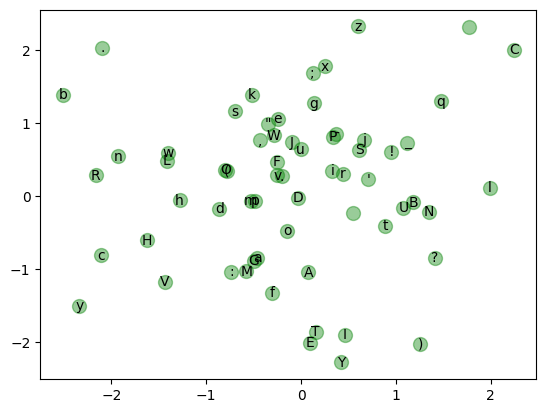

In [25]:
emb = model.emb.weight.detach().numpy()
plt.scatter(emb[:, 0], emb[:, 1], color='green', alpha=0.4, s=100)

for i, e in enumerate(emb):
    txt = decode([i])
    plt.text(e[0], e[1], txt, ha='center', va='center')
plt.show()

9900


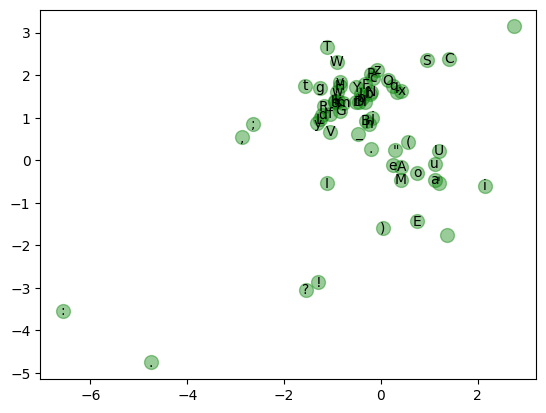

In [59]:
# trining loop
for epoch in range(10000):
    logits = model(X) # batch gradient descend
    loss = F.cross_entropy(logits, y)  # cross-entropy loss between predictions and true labels y

    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients via backpropagation
    optimizer.step()       # Update model weights
    lossi.append(loss.item())  # track loss

    if epoch % 100 == 0:
        clear_output(wait=True)  # Clears previous output 
        print(epoch)  # Print current epoch
        emb = model.emb.weight.detach().numpy()  # Extract embedding weights
        plt.scatter(emb[:, 0], emb[:, 1], color='green', alpha=0.4, s=100)  # Plot embeddings

        for i, e in enumerate(emb):
            txt = decode([i])  # Decode index to a label 
            plt.text(e[0], e[1], txt, ha='center', va='center')  # Annotate points
        plt.show()

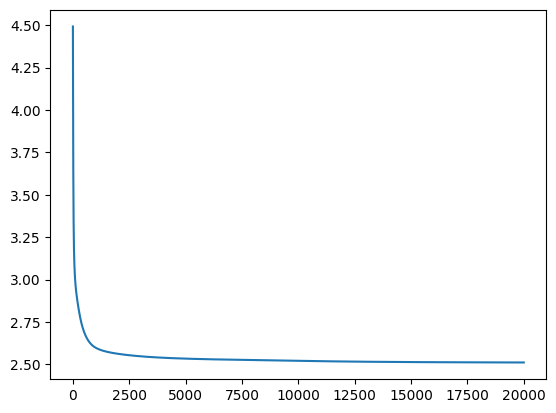

In [61]:
plt.plot(lossi)
plt.show()

In [62]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': lossi[-1],
}
torch.save(checkpoint, 'ngram_checkpoints.pth')

In [ ]:
def generate_text(model, start_text='I H', block_size=3, max_new_tokens=100, temperature=1.0):
    """
    Generate text based on the provided model and starting input text.

    Parameters:
    - model: The trained model (NGram in this case).
    - start_text: The initial text to start the generation from.
    - block_size: The number of previous tokens to consider for prediction (context window).
    - max_new_tokens: The maximum number of new tokens to generate.
    - temperature: The temperature for sampling (higher values lead to more randomness).
    
    Returns:
    - Generated text.
    """
    model.eval()  # Set the model to evaluation mode (no gradient calculation)
    
    # Encode the start text 
    input_seq = torch.tensor(encode(start_text)).unsqueeze(0)  # Add batch dimension (B=1)
    output_text = start_text  # Initialize output with the starting text

    for _ in range(max_new_tokens):
        # Forward pass through the model to get logits (raw predictions)
        logits = model(input_seq)
        
        # Apply temperature to the logits to control randomness
        logits = logits[:, -1] / temperature  # Adjust logits by temperature
        probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        
        # Sample from the probability distribution (use multinomial for randomness)
        ix = torch.multinomial(probs, num_samples=1).item()  # Get predicted index
        
        # Decode the predicted index to a character and append to the output text
        predicted_char = decode([ix])
        output_text += predicted_char
        
        # Update the input sequence (shift and append the new token)
        input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[ix]])], dim=1)

    return output_text


In [64]:
# Example
generated_text = generate_text(model, start_text='I H', block_size=3, max_new_tokens=100, temperature=1.0)
print(generated_text)

I H....................................................................................................


In [36]:
import time
from IPython.display import clear_output

In [66]:
input_ = 'I H'
output = input_

for i in range(100):
    logits = model(torch.tensor(encode(input_)).unsqueeze(0))
    probs = torch.softmax(logits, dim=-1).squeeze()

    # ix = logits.argmax(dim=-1).item()
    ix = torch.multinomial(probs, num_samples=1).item()
    input_ = input_[1:] + decode([ix])
    output += decode([ix])
    print(output)
    clear_output(wait=True)
    time.sleep(0.1)

I He I pom muaped hhy foe iat; Ger ewa-d wher th te vaub hre hiravtse thaone reryir om forewiV Gaeltaim
